In [1]:
import torch
torch.manual_seed(48)
import torch.random as random
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import IterableDataset, Dataset, DataLoader
from tqdm.auto import tqdm
import numpy as np
np.random.seed(48)
import matplotlib.pyplot as plt
from split_MNIST import SplitMNIST
#from split_CIFAR10 import SplitCIFAR10
# Enable gpu acceleration if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)

In [2]:
train_dataset = SplitMNIST()
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=train_dataset.transform, target_transform=torch.tensor)

In [3]:
class ReplayCNN(nn.Module):
    def __init__(self, in_shape=(1, 28, 28), conv_hidden_features=16, hidden_features=64, conv_depth=2, ff_depth=3, classes=2, max_replay=512):
        super(ReplayCNN, self).__init__()
        self.max_replay = max_replay
        self.replay_batch_size = 32
        self.items_per_replay = 1
        input_features = in_shape[0]
        self.feature_extractor = nn.Sequential()
        for i in range(conv_depth):
            in_features = input_features if i == 0 else conv_hidden_features
            out_features = conv_hidden_features
            self.feature_extractor.append(nn.Conv2d(in_features, out_features, kernel_size=3, padding=1, padding_mode='reflect'))
            self.feature_extractor.append(nn.BatchNorm2d(out_features))
            self.feature_extractor.append(nn.ReLU())
            self.feature_extractor.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.feature_extractor.append(nn.Flatten())
        self.classifier = nn.Sequential()
        for i in range(ff_depth):
            in_features = conv_hidden_features * (in_shape[1]//(2**conv_depth) * in_shape[2]//(2**conv_depth)) if i == 0 else hidden_features
            out_features = hidden_features
            self.classifier.append(nn.Linear(in_features, out_features))
            self.classifier.append(nn.BatchNorm1d(out_features))
            self.classifier.append(nn.ReLU())
        self.classifier.append(nn.Dropout(0.5))
        self.classes = classes
        self.last_layer = nn.Linear(hidden_features, classes)

        self.replay_buffer = []
        self.class_balanced_replay_buffer = [[] for _ in range(classes)]
        self.class_balancing = True
        self.sgd_params = {
            'lr': 1e-3,
            'momentum': 0.9,
            'weight_decay': 1e-4,
        }
        model_parameters = list(self.feature_extractor.parameters()) + list(self.classifier.parameters())
        self.model_optimizer = torch.optim.Adam(model_parameters, lr=1e-3)
        self.last_layer_optimizer = torch.optim.SGD(self.last_layer.parameters(), **self.sgd_params)
        self.criterion = nn.CrossEntropyLoss()
        self.kd_criterion = nn.MSELoss()
        self.kd_weight = 0.5
        self.eval()
    
    def add_class(self):
        self.class_balanced_replay_buffer.append([])
        old_weight = self.last_layer.weight.data.clone()
        old_weight.requires_grad = True
        old_bias = self.last_layer.bias.data.clone()
        old_bias.requires_grad = True
        self.last_layer = nn.Linear(self.last_layer.in_features, self.classes + 1)
        self.last_layer.weight.data[:self.classes] = old_weight
        self.last_layer.bias.data[:self.classes] = old_bias
        self.classes += 1
        self.last_layer_optimizer = torch.optim.SGD(self.last_layer.parameters(), **self.sgd_params)

    def add_experience(self, input, target):
        if self.class_balancing:
            if sum([len(buffer) for buffer in self.class_balanced_replay_buffer]) >= self.max_replay:
                bucket_idx = 0
                for i, buffer in enumerate(self.class_balanced_replay_buffer):
                    if len(buffer) > len(self.class_balanced_replay_buffer[bucket_idx]):
                        bucket_idx = i
                idx = np.random.randint(0, len(self.class_balanced_replay_buffer[bucket_idx]))
                self.class_balanced_replay_buffer[bucket_idx].pop(idx)
            self.class_balanced_replay_buffer[target.item()].append((input, None))
        else:
            if len(self.replay_buffer) >= self.max_replay:
                idx = np.random.randint(0, len(self.replay_buffer))
                self.replay_buffer[idx] = (input, target, None)
            else:
                self.replay_buffer.append((input, target, None))
    
    def _get_replay_buffer_as_tensor(self):
        if self.class_balancing:
            if sum([len(buffer) for buffer in self.class_balanced_replay_buffer]) == 0:
                return None
        else:
            if len(self.replay_buffer) == 0:
                return None
        
        inputs = []
        targets = []
        old_outputs = []
        indices = []

        if self.class_balancing:
            while len(inputs) < self.replay_batch_size:
                target = np.random.randint(0, self.classes)
                buffer = self.class_balanced_replay_buffer[target]
                if len(buffer) == 0:
                    continue
                idx = np.random.randint(0, len(buffer))
                input, old_output = buffer[idx]
                inputs.append(input)
                targets.append(torch.tensor(target, dtype=torch.long))
                old_outputs.append(old_output)
                indices.append((target, idx))
        else:
            while len(inputs) < self.replay_batch_size:
                idx = np.random.randint(0, len(self.replay_buffer))
                input, target, old_output = self.replay_buffer[idx]
                inputs.append(input)
                targets.append(target)
                old_outputs.append(old_output)
                indices.append(idx)

        inputs = torch.stack(inputs)
        targets = torch.stack(targets)
        
        # old outputs can be of different lengths so we pad them
        old_outputs = torch.zeros((len(old_outputs), self.classes))
        # we will also need a mask to apply the loss only to the valid outputs
        mask = torch.zeros((len(old_outputs), self.classes), dtype=torch.bool)
        for i, output in enumerate(old_outputs):
            if output is not None:    
                old_outputs[i, :output.shape[0]] = output
                mask[i, :output.shape[0]] = True
        
        return inputs, targets, old_outputs, mask, indices
    
    def _set_old_outputs(self, indices, old_outputs):
        if self.class_balancing:
            for j, (target, i) in enumerate(indices):
                input, _ = self.class_balanced_replay_buffer[target][i]
                self.class_balanced_replay_buffer[target][i] = (input, old_outputs[j])
        else:
            for i, idx in enumerate(indices):
                input, target, _ = self.replay_buffer[idx]
                self.replay_buffer[idx] = (input, target, old_outputs[i])

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        x = self.last_layer(x)
        return x
    
    def replay(self):
        self.train()
        batch = self._get_replay_buffer_as_tensor()
        if batch is None:
            return 0.0, 0.0
        self.model_optimizer.zero_grad()
        self.last_layer_optimizer.zero_grad()
        inputs, targets, old_outputs, mask, indices = batch
        outputs: torch.Tensor = self(inputs)
        accuracy: torch.Tensor = (outputs.argmax(dim=1) == targets).float().mean()
        loss: torch.Tensor = self.criterion(outputs, targets) + self.kd_weight * self.kd_criterion(outputs[mask], old_outputs[mask])
        loss.backward()
        self.model_optimizer.step()
        self.last_layer_optimizer.step()
        self._set_old_outputs(indices, outputs.detach())
        return loss.item(), accuracy.item()

    def fit(self, train_dataset: IterableDataset, test_dataset: Dataset):
        test_batch_size = 32
        loading_bar = tqdm(train_dataset, desc="Training", total=len(train_dataset))
        for item_number, item in enumerate(loading_bar):
            x, y, task = item
            x = x.to(device)
            y = y.to(device)
            while y.max() >= self.classes:
                self.add_class()
            self.add_experience(x, y)
            if item_number % self.items_per_replay == 0 and item_number > 0:
                loss, accuracy = self.replay()
                loading_bar.set_postfix(loss=loss, accuracy=f"{accuracy:.2%}", classes=self.classes)
        test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True, generator=torch.Generator(device=device))
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            loading_bar = tqdm(test_loader, desc="Testing", total=len(test_loader))
            confusion_matrix = torch.zeros(10, 10, dtype=torch.int64)
            for x, y in loading_bar:
                x = x.to(device)
                y = y.to(device)
                outputs = self(x)
                total += y.shape[0]
                correct += (outputs.argmax(dim=1) == y).sum().item()
                accuracy = correct / total
                confusion_matrix += torch.bincount(y * 10 + outputs.argmax(dim=1), minlength=100).reshape(10, 10)
                loading_bar.set_postfix(accuracy=f"{accuracy:.2%}")
        return confusion_matrix


In [4]:
model = ReplayCNN()


In [5]:
confusion_matrix = model.fit(train_dataset, test_dataset)

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

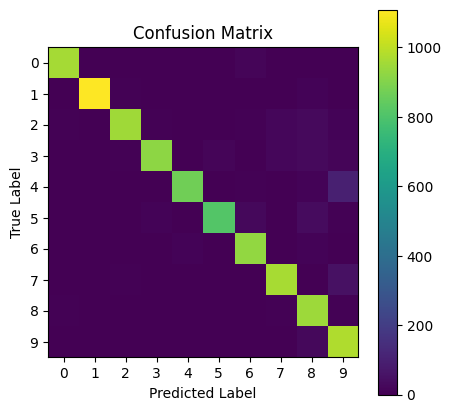

In [6]:
plt.figure(figsize=(5, 5))
plt.imshow(confusion_matrix.cpu(), interpolation='nearest')
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.show()